# Menu <a class="anchor" id="menu"></a>
* [1. Exploratory Data Analysis (EDA)](#eda)
* [2. Experimenting various models](#models)
    * [2.0 Preparing the dataset](#models_prepare)
    * [2.1 Establishing a baseline with DummyClassifier](#models_dummy)
    * [2.2 Logistic Regression](#models_linear)
    * [2.3 Decision Tree](#models_decision_tree)
    * [2.4 Random Forest](#models_random_forest)
    * [2.5 XGBoost](#models_xgboost)
* [3. Impoving the models with GreadSearchCV](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Impoving the models with solutions for Imbalanced datasets](#models_balanced)
    * [4.1 Balanced Logistic Regression Grid](#models_linear_balanced)
    * [4.2 Balanced Decision Tree Grid](#models_decision_tree_balanced)
    * [4.3 Balanced Random Forest Grid](#models_random_forest_balanced)
    * [4.4 Balanced XGBoost Grid](#models_xgboost_balanced)

In [1]:
import time
import copy as cp

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from zipfile import ZipFile

#### ---- Let's load the columns selected in the EDA ----

In [2]:
filename = 'data/dtypes_low.csv'

dtypes_df = pd.read_csv(filename, sep=',', index_col=0)

cols_to_keep = dtypes_df.columns
dtypes = dtypes_df.to_dict('records')[0]

#### \<test>

#### \<\test>

In [3]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [4]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    ######usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

data_application_train.shape

(307511, 122)

#### \<test>

#### \<\test>

## Feature Engigeering

In [5]:
sample_size_base = 30000
sample_size_grid = 10000
data_clean = data_application_train[:sample_size_base].copy()

In [6]:
import missingno as msno

# Experimenting various models <a class="anchor" id="models"></a> [⇪](#menu)

## 0. Preparing the dataset <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Splitting the dataset between `train`, `validation` and `test` sets

- The `training set` is used to train various models.
- The `validation set` is used to select a model: we choose the one with the best performance on this set.
- The `test set` is used to estimate the generalization performance of the selected model.

Alternatively, instead of creating those three sets, we can separate the data into only two parts: a `training set` and a `test set` and then do a cross-validation on the `training set`. This allows us to choose a model (the one with the best performance), which we will then train on the whole `training set` and test on the `test set`. It is this final performance that is the best approximation of the performance that the model will be able to achieve on new data.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_full = data_clean.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_clean['TARGET']

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.10,
                                                random_state=0,
                                                stratify=Y_full)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(
                                                X_train_full, 
                                                y_train_full, 
                                                test_size=X_test.shape[0], 
                                                random_state=0,
                                                stratify=y_train_full)

In [11]:
print(f"X_train: {X_train.shape[0] / X_full.shape[0] * 100}% | X_valid: {X_valid.shape[0] / X_full.shape[0] * 100}% | X_test: {X_test.shape[0] / X_full.shape[0]* 100}%")

X_train: 80.0% | X_valid: 10.0% | X_test: 10.0%


### Encoding the qualitative variables

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

In [13]:
oe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() == 2]
ohe_targets = [x for x in X_train_full.select_dtypes(exclude='number').columns if X_train_full[x].nunique() > 2]

In [14]:
def fit_labels(data):
    """ Prepare the encoder for the ordinal columns.
    - Columns with 2 unique values are encoded using an OrdinalEncoder
    - Columns with more than 2 unique values are encoded using a OneHotEncoder
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    oe_targets = []
    ohe_targets = []
    
    for col in data.select_dtypes(exclude='number').columns:
        if data[col].nunique() == 2:
            oe_targets.append(col)
        else:
            ohe_targets.append(col)
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_mode):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### Fit the encoders

In [15]:
oe_model, ohe_model = fit_labels(X_train)

#### Transform the `training`, `validation` and `testing` sets

In [16]:
X_train_full = transform_labels(X_train_full, oe_model, ohe_model)
X_train = transform_labels(X_train, oe_model, ohe_model)
X_valid = transform_labels(X_valid, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations

In [17]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [18]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

In [19]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [20]:
X_train_full = impute(X_train_full, imputer_model)
X_train = impute(X_train, imputer_model)
X_valid = impute(X_valid, imputer_model)
X_test = impute(X_test, imputer_model)

(27000, 242) <class 'pandas.core.frame.DataFrame'>
(24000, 242) <class 'pandas.core.frame.DataFrame'>
(3000, 242) <class 'pandas.core.frame.DataFrame'>
(3000, 242) <class 'pandas.core.frame.DataFrame'>


<AxesSubplot:>

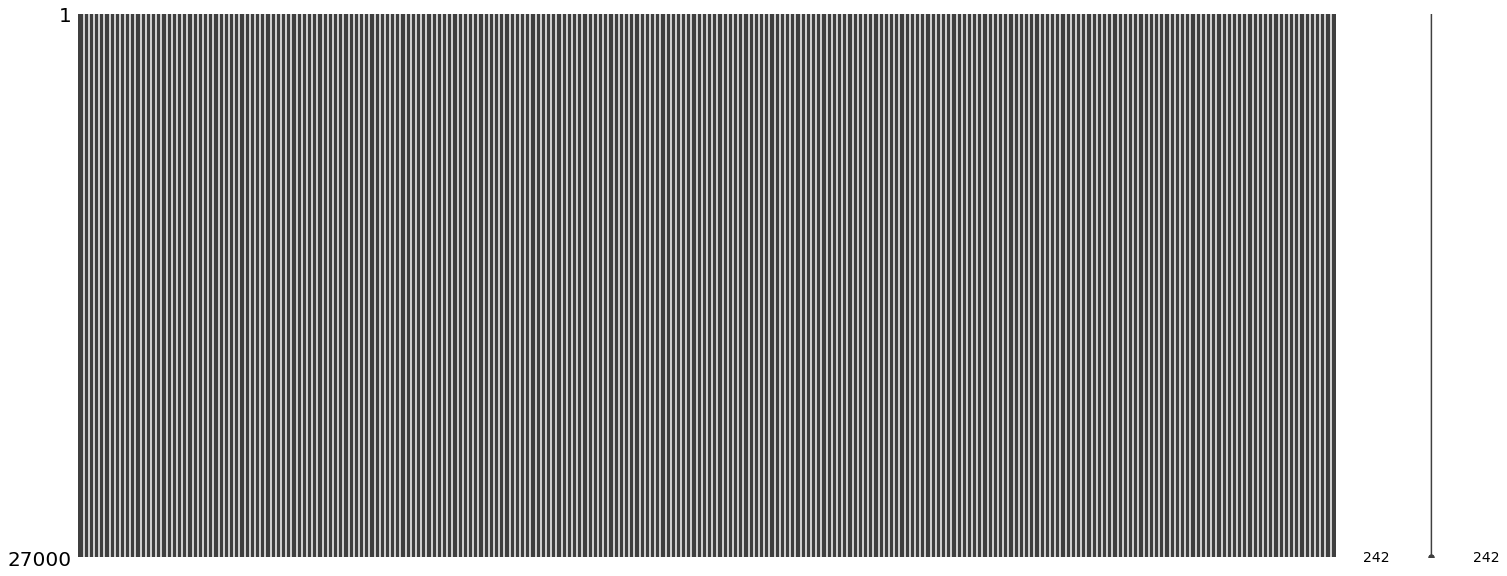

In [21]:
msno.matrix(X_train_full)

### Normalizing the dataset

In [22]:
from sklearn.preprocessing import RobustScaler

In [23]:
def fit_normalizer(data):
       
    robust_scaler = RobustScaler()
    robust_scaler.fit(data)
    
    return robust_scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [24]:
model_scaler = fit_normalizer(X_train)

In [25]:
X_train_full = normalize(X_train_full, model_scaler)
X_train = normalize(X_train, model_scaler)
X_valid = normalize(X_valid, model_scaler)
X_test = normalize(X_test, model_scaler)

### Define some report functions

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score

In [27]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---\n\n", report)

In [28]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---\n")
    plt.show()

In [29]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None):
    
    print(f"--- ROC AUC ---\n")
    auc_scores = {}
    last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt

    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        alpha_v = 1 if i == last_index-1 else 0.5
        
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    return auc_scores

In [30]:
scores = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores.csv'
scores.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, **others):
    
    if X_ref is None:
        X_ref = X_valid
        
    if y_ref is None:
        y_ref = y_valid
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    
    rocauc_value = roc_auc_score(y_ref, y_pred_proba)
    f1_value = f1_score(y_ref, y_pred)
    accuracy_value = accuracy_score(y_ref, y_pred)
    precision_value = precision_score(y_ref, y_pred, zero_division=0)
    recall_value = recall_score(y_ref, y_pred)
    
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])
    TN, FP, FN, TP = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    
    # Register score and replace if it already exists
    if register:
        threshold = threshold if threshold else 0.5
        idx = np.where(scores.Method == method_name)[0]        
        idx = idx[0] if idx.size > 0 else len(scores.index)
        scores.loc[idx] = [method_name, threshold, param_grid, rocauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]
        
        scores.to_csv(scores_path, index=False)
    
    # Basic report
    print(f"--- {method_name} ---\n\nROC AUC:{rocauc_value}\nF1-score:{f1_value}\nRecall:{recall_value}\n")
    
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)

In [31]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [32]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [33]:
from sklearn.metrics import SCORERS
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV, GridSearchCV

def fit_model(model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
    
    if scoring not in SCORERS.keys():
        raise Exception(f"This scoring method isn't supported; check the list below:\n{SCORERS.keys()}")
        
    fit_time = time.perf_counter()
    grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time
    
    scores = []
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    
    for i in range(n_splits):
        score = grid_model.cv_results_[f'split{i}_test_score'].mean()
        scores.append(score)
        print(f"{scoring.upper()}: {score}")
        
    scores = pd.Series(scores)

    print(f"\nMEAN {scoring.upper()}: {scores.mean():.4f} with STD: {scores.std():.4f}")    
    #print(f"\nFULL-SET {scoring.__name__.upper()}: {overall_score:.4f}")
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid}

In [34]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

#### Let's define the cross-validation method

In [35]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [36]:
import FreeMobileSMS as sms
sms.send("Data preparation done", stop=False)

In [37]:
y_train.value_counts()

0    22077
1     1923
Name: TARGET, dtype: int64

In [38]:
y_valid.value_counts()

0    2760
1     240
Name: TARGET, dtype: int64

In [39]:
y_test.value_counts()

0    2760
1     240
Name: TARGET, dtype: int64

In [40]:
for r in skfold.split(X_train.to_numpy(), y_train.to_numpy()):
    print(y_train.iloc[r[1]].value_counts())

0    4416
1     384
Name: TARGET, dtype: int64
0    4416
1     384
Name: TARGET, dtype: int64
0    4415
1     385
Name: TARGET, dtype: int64
0    4415
1     385
Name: TARGET, dtype: int64
0    4415
1     385
Name: TARGET, dtype: int64


## 1. Establishing baseline with Dummy Classifier <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [41]:
from sklearn.dummy import DummyClassifier

In [42]:
grd_dummy = fit_model( 
    DummyClassifier(),
    param_grid={ 'random_state':[0], 'strategy':['stratified'] }, 
    cv = skfold
)

ROC_AUC: 0.46195652173913043
ROC_AUC: 0.4438202247191011
ROC_AUC: 0.4631578947368421
ROC_AUC: 0.6631578947368421
ROC_AUC: 0.5726495726495727

MEAN ROC_AUC: 0.5209 with STD: 0.0944


--- DummyClassifier ---

ROC AUC:0.498731884057971
F1-score:0.08429118773946359
Recall:0.09166666666666666

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.91      2760
Prediction = 1       0.08      0.09      0.08       240

      accuracy                           0.84      3000
     macro avg       0.50      0.50      0.50      3000
  weighted avg       0.85      0.84      0.85      3000

--- Confusion Matrix ---



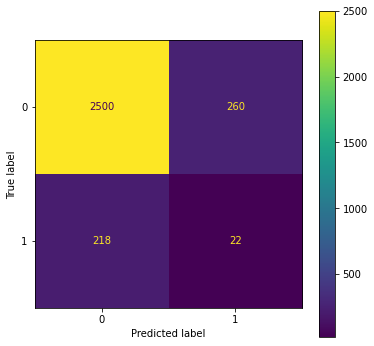

--- ROC AUC ---



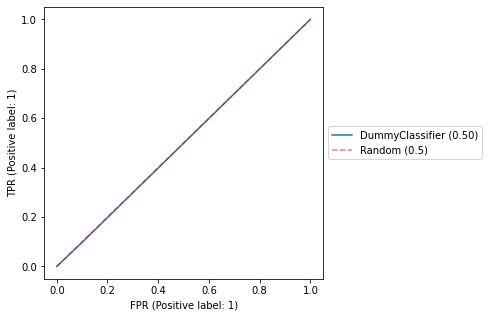

In [43]:
get_scores(get_model_name(grd_dummy['model']), **grd_dummy, register=True)

> - The **recall** means "how many of this class you find over the whole number of element of this class"
> - The **precision** will be "how many are correctly classified among that class"
> - The **f1-score** is the harmonic mean between precision & recall
> - The **support** is the number of occurence of the given class in your dataset


## 2. Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
grd_log = fit_model(
    LogisticRegression(), 
    param_grid={ 'random_state':[0], 'max_iter':[3000] },  
    cv = skfold
)

ROC_AUC: 0.7880184331797235
ROC_AUC: 0.6700715015321757
ROC_AUC: 0.7265745007680491
ROC_AUC: 0.6702127659574468
ROC_AUC: 0.6766304347826086

MEAN ROC_AUC: 0.7063 with STD: 0.0514


--- Basic LogisticRegression ---

ROC AUC:0.726893115942029
F1-score:0.008064516129032258
Recall:0.004166666666666667

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.12      0.00      0.01       240

      accuracy                           0.92      3000
     macro avg       0.52      0.50      0.48      3000
  weighted avg       0.86      0.92      0.88      3000

--- Confusion Matrix ---



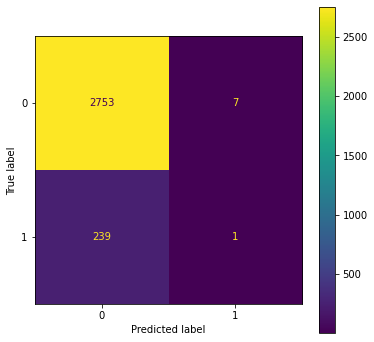

--- ROC AUC ---



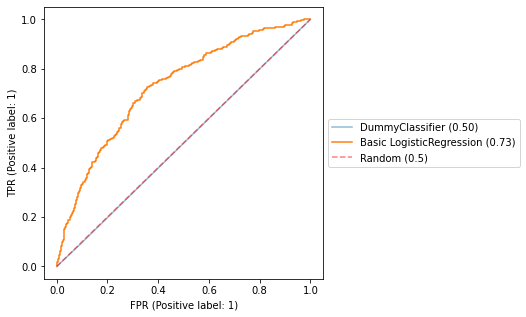

In [46]:
get_scores(f"Basic {get_model_name(grd_log['model'])}", **grd_log, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [47]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.21897810218978103) for this model is reached with a threshold of 0.22


--- Basic LogisticRegression [w/thresholding] ---

ROC AUC:0.726893115942029
F1-score:0.21897810218978103
Recall:0.1875

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.95      0.94      2760
Prediction = 1       0.26      0.19      0.22       240

      accuracy                           0.89      3000
     macro avg       0.60      0.57      0.58      3000
  weighted avg       0.88      0.89      0.88      3000

--- Confusion Matrix ---



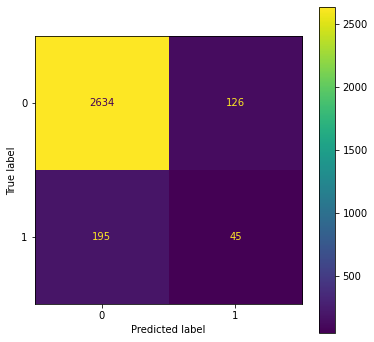

In [48]:
get_scores(f"Basic {get_model_name(grd_log['model'])} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [50]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

ROC_AUC: 0.5396825396825398
ROC_AUC: 0.6799242424242425
ROC_AUC: 0.4635416666666667
ROC_AUC: 0.5506715506715507
ROC_AUC: 0.5407801418439717

MEAN ROC_AUC: 0.5549 with STD: 0.0781


--- Basic DecisionTreeClassifier ---

ROC AUC:0.5232789855072464
F1-score:0.12424849699398796
Recall:0.12916666666666668

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.92      0.92      2760
Prediction = 1       0.12      0.13      0.12       240

      accuracy                           0.85      3000
     macro avg       0.52      0.52      0.52      3000
  weighted avg       0.86      0.85      0.86      3000

--- Confusion Matrix ---



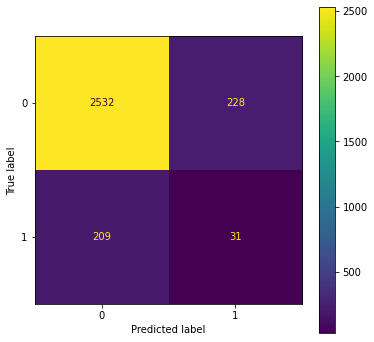

--- ROC AUC ---



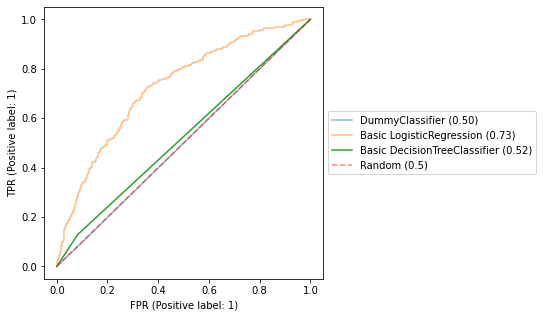

In [51]:
get_scores(f"Basic {get_model_name(grd_dt['model'])}", **grd_dt, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [52]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.12424849699398796) for this model is reached with a threshold of 0.125


--- Basic DecisionTreeClassifier [w/thresholding] ---

ROC AUC:0.5232789855072464
F1-score:0.12424849699398796
Recall:0.12916666666666668

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.92      0.92      2760
Prediction = 1       0.12      0.13      0.12       240

      accuracy                           0.85      3000
     macro avg       0.52      0.52      0.52      3000
  weighted avg       0.86      0.85      0.86      3000

--- Confusion Matrix ---



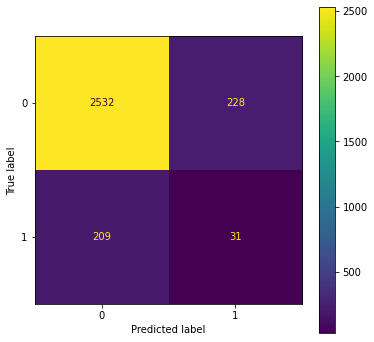

In [53]:
get_scores(f"Basic {get_model_name(grd_dt['model'])} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

## 4. Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
grd_rf = fit_model(
    RandomForestClassifier(n_jobs=-1), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold
)

ROC_AUC: 0.6683333333333333
ROC_AUC: 0.7844444444444444
ROC_AUC: 0.7694444444444445
ROC_AUC: 0.4004085801838611
ROC_AUC: 0.4719101123595506

MEAN ROC_AUC: 0.6189 with STD: 0.1745


--- Basic RandomForestClassifier ---

ROC AUC:0.6908612620772947
F1-score:0.0
Recall:0.0

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      2760
Prediction = 1       0.00      0.00      0.00       240

      accuracy                           0.92      3000
     macro avg       0.46      0.50      0.48      3000
  weighted avg       0.85      0.92      0.88      3000

--- Confusion Matrix ---



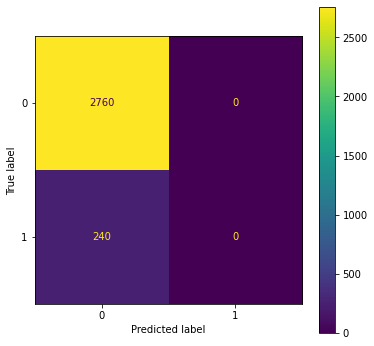

--- ROC AUC ---



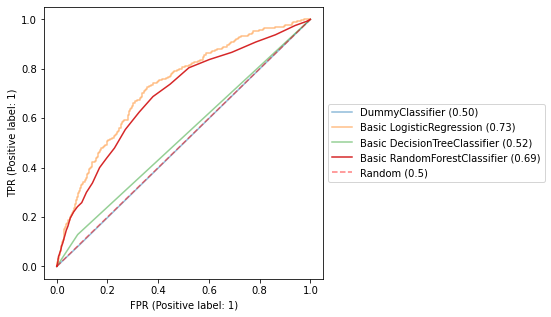

In [56]:
get_scores(f"Basic {get_model_name(grd_rf['model'])}", **grd_rf, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [57]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.21658986175115205) for this model is reached with a threshold of 0.2


--- Basic RandomForestClassifier [w/thresholding] ---

ROC AUC:0.6908612620772947
F1-score:0.21658986175115205
Recall:0.19583333333333333

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.95      0.94      2760
Prediction = 1       0.24      0.20      0.22       240

      accuracy                           0.89      3000
     macro avg       0.59      0.57      0.58      3000
  weighted avg       0.88      0.89      0.88      3000

--- Confusion Matrix ---



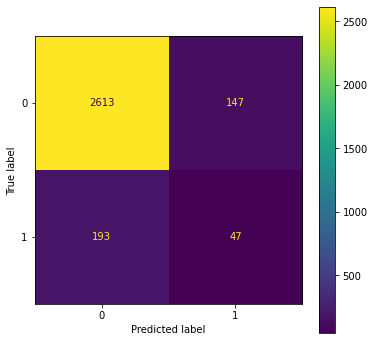

In [58]:
get_scores(f"Basic {get_model_name(grd_rf['model'])} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

## 5. XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [59]:
from xgboost import XGBClassifier

In [60]:
param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
}

grd_xgb = fit_model(
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

ROC_AUC: 0.4066666666666667
ROC_AUC: 0.6312056737588653
ROC_AUC: 0.5085910652920962
ROC_AUC: 0.7019969278033794
ROC_AUC: 0.7705263157894737

MEAN ROC_AUC: 0.6038 with STD: 0.1467


--- Basic XGBClassifier ---

ROC AUC:0.7175709541062802
F1-score:0.06844106463878327
Recall:0.0375

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      2760
Prediction = 1       0.39      0.04      0.07       240

      accuracy                           0.92      3000
     macro avg       0.66      0.52      0.51      3000
  weighted avg       0.88      0.92      0.89      3000

--- Confusion Matrix ---



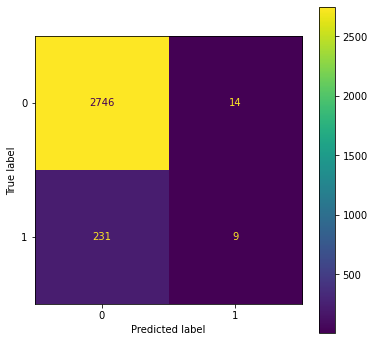

--- ROC AUC ---



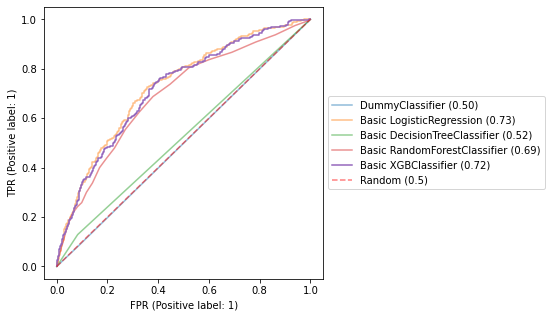

In [61]:
get_scores(f"Basic {get_model_name(grd_xgb['model'])}", **grd_xgb, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [62]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.21596244131455403) for this model is reached with a threshold of 0.221


--- Basic XGBClassifier [w/thresholding] ---

ROC AUC:0.7175709541062802
F1-score:0.21596244131455403
Recall:0.19166666666666668

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.95      0.94      2760
Prediction = 1       0.25      0.19      0.22       240

      accuracy                           0.89      3000
     macro avg       0.59      0.57      0.58      3000
  weighted avg       0.88      0.89      0.88      3000

--- Confusion Matrix ---



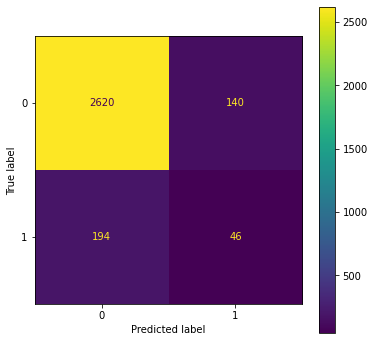

In [63]:
get_scores(f"Basic {get_model_name(grd_xgb['model'])} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 6. Review scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [64]:
scores

,Method,threshold,params,ROC AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,0.500,"{'random_state': [0], 'strategy': ['stratified']}",0.498732,0.084291,0.840667,0.078014,0.091667,22,2500,260,218,1.213294,0.001280
1,Basic LogisticRegression,0.500,"{'random_state': [0], 'max_iter': [3000]}",0.726893,0.008065,0.918000,0.125000,0.004167,1,2753,7,239,35.735701,0.025318
2,Basic LogisticRegression [w/thresholding],0.220,"{'random_state': [0], 'max_iter': [3000]}",0.726893,0.218978,0.893000,0.263158,0.187500,45,2634,126,195,35.735701,0.010839
3,Basic DecisionTreeClassifier,0.500,{'random_state': [0]},0.523279,0.124248,0.854333,0.119691,0.129167,31,2532,228,209,2.119543,0.011485
4,Basic DecisionTreeClassifier [w/thresholding],0.125,{'random_state': [0]},0.523279,0.124248,0.854333,0.119691,0.129167,31,2532,228,209,2.119543,0.005133
5,Basic RandomForestClassifier,0.500,{'random_state': [0]},0.690861,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.552000,0.097967
6,Basic RandomForestClassifier [w/thresholding],0.200,{'random_state': [0]},0.690861,0.216590,0.886667,0.242268,0.195833,47,2613,147,193,2.552000,0.051578
7,Basic XGBClassifier,0.500,"{'seed': [0], 'objective': ['binary:logistic']...",0.717571,0.068441,0.918333,0.391304,0.037500,9,2746,14,231,9.429600,0.031730
8,Basic XGBClassifier [w/thresholding],0.221,"{'seed': [0], 'objective': ['binary:logistic']...",0.717571,0.215962,0.888667,0.247312,0.191667,46,2620,140,194,9.429600,0.017824


In [65]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']]

,Method,ROC AUC,F1 score,Recall
0,DummyClassifier,0.498732,0.084291,0.091667
1,Basic LogisticRegression,0.726893,0.008065,0.004167
2,Basic LogisticRegression [w/thresholding],0.726893,0.218978,0.187500
3,Basic DecisionTreeClassifier,0.523279,0.124248,0.129167
4,Basic DecisionTreeClassifier [w/thresholding],0.523279,0.124248,0.129167
5,Basic RandomForestClassifier,0.690861,0.000000,0.000000
6,Basic RandomForestClassifier [w/thresholding],0.690861,0.216590,0.195833
7,Basic XGBClassifier,0.717571,0.068441,0.037500
8,Basic XGBClassifier [w/thresholding],0.717571,0.215962,0.191667


In [66]:
sms.send("Basic done", stop=False)

# Improving the models with GridSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

In [67]:
X_train_full = X_train_full[:sample_size_grid]
y_train_full = y_train_full[:sample_size_grid]

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [68]:
param_grid = [
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [69]:
grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

ROC_AUC: 0.5956495715042067
ROC_AUC: 0.6595249413030284
ROC_AUC: 0.6537865379996235
ROC_AUC: 0.5390311826197463
ROC_AUC: 0.5472246697236626

MEAN ROC_AUC: 0.5990 with STD: 0.0569


In [70]:
grd_log['grid'].best_params_

{'C': 0.01,
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

In [71]:
get_scores(f"Grid {get_model_name(grd_log['model'])}", **grd_log, register=False, simple=True)

--- Grid LogisticRegression ---

ROC AUC:0.7271105072463767
F1-score:0.0
Recall:0.0



#### Let's find the best threshold *(based on F1 score)*

In [72]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2068965517241379) for this model is reached with a threshold of 0.20700000000000002


--- Grid LogisticRegression [w/thresholding] ---

ROC AUC:0.7271105072463767
F1-score:0.2068965517241379
Recall:0.175

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.94      2760
Prediction = 1       0.25      0.17      0.21       240

      accuracy                           0.89      3000
     macro avg       0.59      0.57      0.57      3000
  weighted avg       0.88      0.89      0.88      3000

--- Confusion Matrix ---



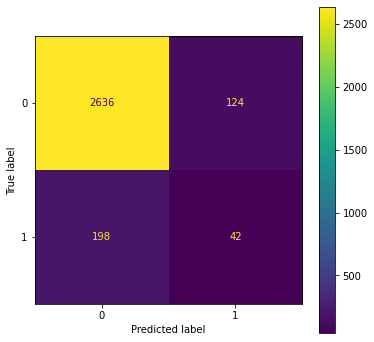

--- ROC AUC ---



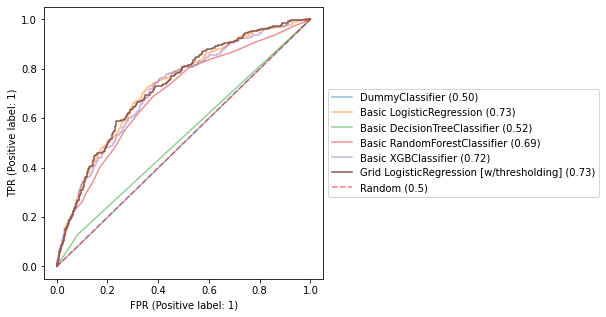

In [73]:
get_scores(f"Grid {get_model_name(grd_log['model'])} [w/thresholding]", **grd_log, threshold=best_threshold, register=True)

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [74]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [75]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

ROC_AUC: 0.5505849687276306
ROC_AUC: 0.5489607888326418
ROC_AUC: 0.5517818991736784
ROC_AUC: 0.5243386446819882
ROC_AUC: 0.5221573389337426

MEAN ROC_AUC: 0.5396 with STD: 0.0149


In [76]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'random_state': 0}

In [77]:
get_scores(f"Grid {get_model_name(grd_dt['model'])}", **grd_dt, register=False, simple=True)

--- Grid DecisionTreeClassifier ---

ROC AUC:0.6807276570048308
F1-score:0.0
Recall:0.0



#### Let's find the best threshold *(based on F1 score)*

In [78]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2046332046332046) for this model is reached with a threshold of 0.189


--- Grid DecisionTreeClassifier [w/thresholding] ---

ROC AUC:0.6807276570048308
F1-score:0.2046332046332046
Recall:0.22083333333333333

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.92      0.92      2760
Prediction = 1       0.19      0.22      0.20       240

      accuracy                           0.86      3000
     macro avg       0.56      0.57      0.56      3000
  weighted avg       0.87      0.86      0.87      3000

--- Confusion Matrix ---



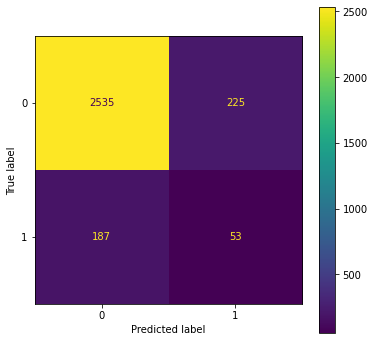

--- ROC AUC ---



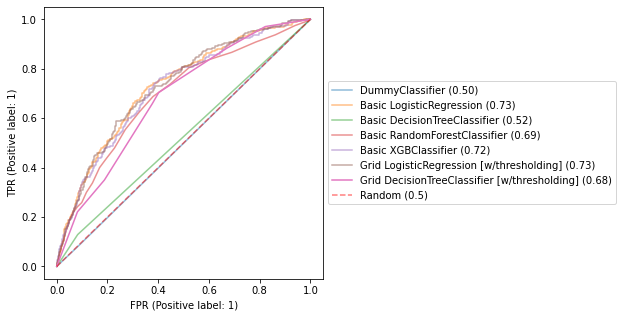

In [79]:
get_scores(f"Grid {get_model_name(grd_dt['model'])} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True)

## 3. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [80]:
param_grid = {
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [81]:
grd_rf = fit_model(
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

ROC_AUC: 0.5540746586808367
ROC_AUC: 0.6599704775067313
ROC_AUC: 0.6433381174302062
ROC_AUC: 0.702149237937604
ROC_AUC: 0.6734274587193954

MEAN ROC_AUC: 0.6466 with STD: 0.0560


In [82]:
grd_rf['grid'].best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 300,
 'random_state': 0}

In [83]:
get_scores(f"Grid {get_model_name(grd_rf['model'])}", **grd_rf, register=False, simple=True)

--- Grid RandomForestClassifier ---

ROC AUC:0.7096950483091787
F1-score:0.0
Recall:0.0



#### Let's find the best threshold *(based on F1 score)*

In [84]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.1911764705882353) for this model is reached with a threshold of 0.199


--- Grid RandomForestClassifier [w/thresholding] ---

ROC AUC:0.7096950483091787
F1-score:0.1911764705882353
Recall:0.1625

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.95      0.94      2760
Prediction = 1       0.23      0.16      0.19       240

      accuracy                           0.89      3000
     macro avg       0.58      0.56      0.57      3000
  weighted avg       0.87      0.89      0.88      3000

--- Confusion Matrix ---



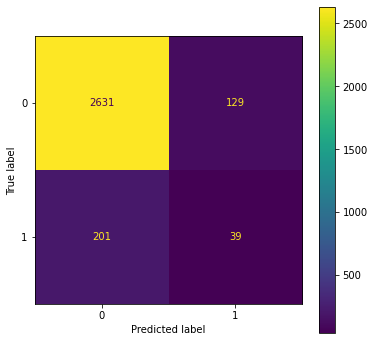

--- ROC AUC ---



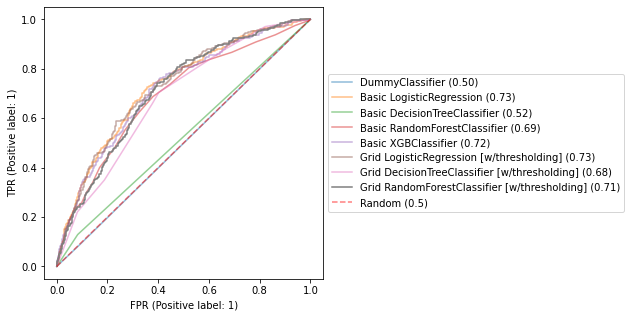

In [85]:
get_scores(f"Grid {get_model_name(grd_rf['model'])} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True)

## 4. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [86]:
from xgboost import XGBClassifier

In [87]:
param_grid = {
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [88]:
grd_xgb = fit_model(
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

ROC_AUC: 0.5516308829131321
ROC_AUC: 0.5961208584582025
ROC_AUC: 0.7123670526749477
ROC_AUC: 0.6912309895072857
ROC_AUC: 0.6193033561294579

MEAN ROC_AUC: 0.6341 with STD: 0.0668


In [89]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 180,
 'nthread': -1,
 'objective': 'binary:logistic',
 'seed': 0}

In [90]:
get_scores(f"Grid {get_model_name(grd_xgb['model'])}", **grd_xgb, register=False, simple=True)

--- Grid XGBClassifier ---

ROC AUC:0.7274328200483091
F1-score:0.008298755186721992
Recall:0.004166666666666667



#### Let's find the best threshold *(based on F1 score)*

In [91]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2047244094488189) for this model is reached with a threshold of 0.211


--- Grid XGBClassifier [w/thresholding] ---

ROC AUC:0.7274328200483091
F1-score:0.2047244094488189
Recall:0.1625

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.95      2760
Prediction = 1       0.28      0.16      0.20       240

      accuracy                           0.90      3000
     macro avg       0.60      0.56      0.58      3000
  weighted avg       0.88      0.90      0.89      3000

--- Confusion Matrix ---



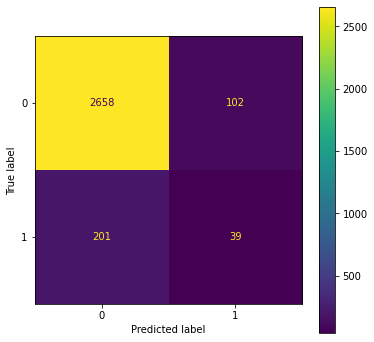

--- ROC AUC ---



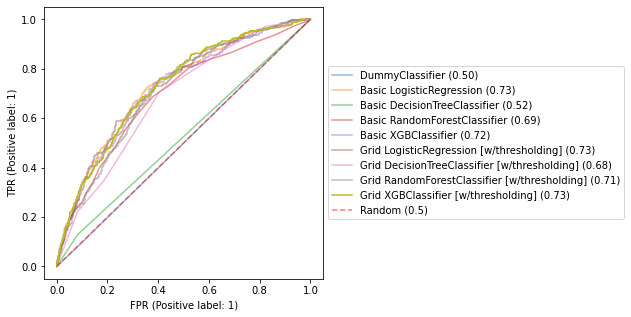

In [92]:
get_scores(f"Grid {get_model_name(grd_xgb['model'])} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True)

## 5. Review scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [93]:
scores

,Method,threshold,params,ROC AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,0.500,"{'random_state': [0], 'strategy': ['stratified']}",0.498732,0.084291,0.840667,0.078014,0.091667,22,2500,260,218,1.213294,0.001280
1,Basic LogisticRegression,0.500,"{'random_state': [0], 'max_iter': [3000]}",0.726893,0.008065,0.918000,0.125000,0.004167,1,2753,7,239,35.735701,0.025318
2,Basic LogisticRegression [w/thresholding],0.220,"{'random_state': [0], 'max_iter': [3000]}",0.726893,0.218978,0.893000,0.263158,0.187500,45,2634,126,195,35.735701,0.010839
3,Basic DecisionTreeClassifier,0.500,{'random_state': [0]},0.523279,0.124248,0.854333,0.119691,0.129167,31,2532,228,209,2.119543,0.011485
4,Basic DecisionTreeClassifier [w/thresholding],0.125,{'random_state': [0]},0.523279,0.124248,0.854333,0.119691,0.129167,31,2532,228,209,2.119543,0.005133
5,Basic RandomForestClassifier,0.500,{'random_state': [0]},0.690861,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.552000,0.097967
6,Basic RandomForestClassifier [w/thresholding],0.200,{'random_state': [0]},0.690861,0.216590,0.886667,0.242268,0.195833,47,2613,147,193,2.552000,0.051578
7,Basic XGBClassifier,0.500,"{'seed': [0], 'objective': ['binary:logistic']...",0.717571,0.068441,0.918333,0.391304,0.037500,9,2746,14,231,9.429600,0.031730
8,Basic XGBClassifier [w/thresholding],0.221,"{'seed': [0], 'objective': ['binary:logistic']...",0.717571,0.215962,0.888667,0.247312,0.191667,46,2620,140,194,9.429600,0.017824
9,Grid LogisticRegression [w/thresholding],0.207,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.727111,0.206897,0.892667,0.253012,0.175000,42,2636,124,198,29.775704,0.005946


In [94]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('Recall', ascending=False)

,Method,ROC AUC,F1 score,Recall
10,Grid DecisionTreeClassifier [w/thresholding],0.680728,0.204633,0.220833
6,Basic RandomForestClassifier [w/thresholding],0.690861,0.216590,0.195833
8,Basic XGBClassifier [w/thresholding],0.717571,0.215962,0.191667
2,Basic LogisticRegression [w/thresholding],0.726893,0.218978,0.187500
9,Grid LogisticRegression [w/thresholding],0.727111,0.206897,0.175000
11,Grid RandomForestClassifier [w/thresholding],0.709695,0.191176,0.162500
12,Grid XGBClassifier [w/thresholding],0.727433,0.204724,0.162500
3,Basic DecisionTreeClassifier,0.523279,0.124248,0.129167
4,Basic DecisionTreeClassifier [w/thresholding],0.523279,0.124248,0.129167
0,DummyClassifier,0.498732,0.084291,0.091667


In [95]:
sms.send("Gridsearch done", stop=False)

# Impoving the models with solutions for Imbalanced datasets <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Balanced Logistic Regression Grid<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [96]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [97]:
grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

ROC_AUC: 0.5819552620743184
ROC_AUC: 0.5885409908870486
ROC_AUC: 0.6307671729485956
ROC_AUC: 0.6364443614718615
ROC_AUC: 0.6782381487981549

MEAN ROC_AUC: 0.6232 with STD: 0.0393


In [98]:
grd_log['grid'].best_params_

{'C': 0.01,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

In [99]:
get_scores(f"Balanced {get_model_name(grd_log['model'])}", **grd_log, register=False, simple=True)

--- Balanced LogisticRegression ---

ROC AUC:0.7273188405797101
F1-score:0.24979321753515304
Recall:0.6291666666666667



#### Let's find the best threshold *(based on F1 score)*

In [100]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.19317678334071778) for this model is reached with a threshold of 0.307


--- Balanced LogisticRegression [w/thresholding] ---

ROC AUC:0.7273188405797101
F1-score:0.19317678334071778
Recall:0.9083333333333333

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.98      0.35      0.51      2760
Prediction = 1       0.11      0.91      0.19       240

      accuracy                           0.39      3000
     macro avg       0.54      0.63      0.35      3000
  weighted avg       0.91      0.39      0.49      3000

--- Confusion Matrix ---



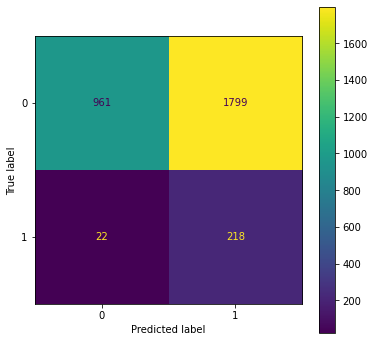

--- ROC AUC ---



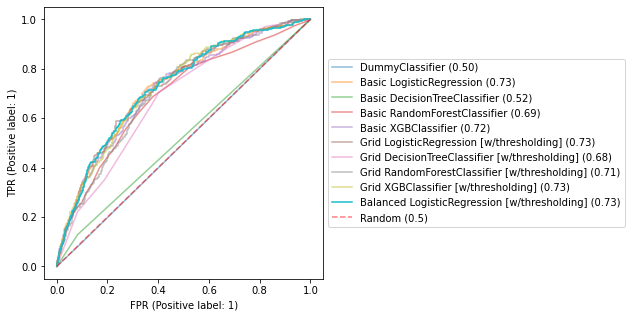

In [101]:
get_scores(f"Balanced {get_model_name(grd_log['model'])} [w/thresholding]", **grd_log, threshold=best_threshold, register=True)

## 2. Balanced Decision Tree Grid <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [102]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2', ], # auto = sqrt
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy']
}

In [103]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

ROC_AUC: 0.5986154715845048
ROC_AUC: 0.563780659786238
ROC_AUC: 0.5629405102326035
ROC_AUC: 0.5244769683310182
ROC_AUC: 0.5041410148548828

MEAN ROC_AUC: 0.5508 with STD: 0.0370


In [104]:
grd_dt['grid'].best_params_

{'ccp_alpha': 0.001,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': None,
 'random_state': 0}

In [105]:
get_scores(f"Balanced {get_model_name(grd_dt['model'])}", **grd_dt, register=False, simple=True)

--- Balanced DecisionTreeClassifier ---

ROC AUC:0.6579430857487922
F1-score:0.2038753159224937
Recall:0.5041666666666667



#### Let's find the best threshold *(based on F1 score)*

In [106]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.1842445114076625) for this model is reached with a threshold of 0.255


--- Balanced DecisionTreeClassifier [w/thresholding] ---

ROC AUC:0.6579430857487922
F1-score:0.1842445114076625
Recall:0.8916666666666667

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.32      0.48      2760
Prediction = 1       0.10      0.89      0.18       240

      accuracy                           0.37      3000
     macro avg       0.54      0.61      0.33      3000
  weighted avg       0.90      0.37      0.46      3000

--- Confusion Matrix ---



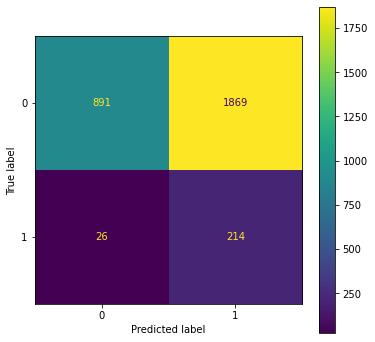

--- ROC AUC ---



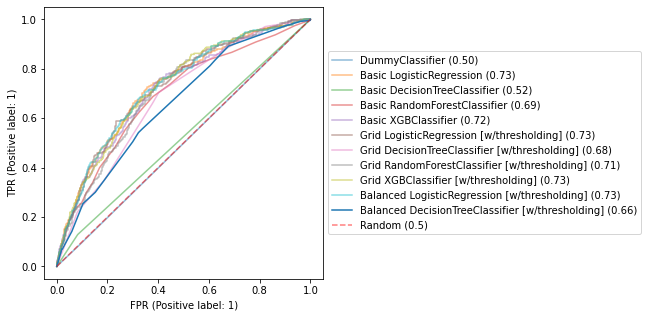

In [107]:
get_scores(f"Balanced {get_model_name(grd_dt['model'])} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True)

## 3. Balanced Random Forest Grid <a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [108]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[0],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'ccp_alpha': [0.1, .01, .001],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'criterion' :['gini', 'entropy'],
    #'n_estimators' :[64, 100, 128, 256, 528]
    'n_estimators' :[100, 200, 300, 400, 500]
}

In [109]:
grd_rf = fit_model(
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

ROC_AUC: 0.6473528581828402
ROC_AUC: 0.5365058403518471
ROC_AUC: 0.7878286036095381
ROC_AUC: 0.7961606858891396
ROC_AUC: 0.6357200156991218

MEAN ROC_AUC: 0.6807 with STD: 0.1104


In [110]:
grd_rf['grid'].best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'n_estimators': 300,
 'random_state': 0}

In [111]:
get_scores(f"Balanced {get_model_name(grd_rf['model'])}", **grd_rf, register=False, simple=True)

--- Balanced RandomForestClassifier ---

ROC AUC:0.6934261775362319
F1-score:0.2295877122069523
Recall:0.5916666666666667



#### Let's find the best threshold *(based on F1 score)*

In [112]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.19904306220095694) for this model is reached with a threshold of 0.397


--- Balanced RandomForestClassifier [w/thresholding] ---

ROC AUC:0.6934261775362319
F1-score:0.19904306220095694
Recall:0.8666666666666667

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.41      0.57      2760
Prediction = 1       0.11      0.87      0.20       240

      accuracy                           0.44      3000
     macro avg       0.54      0.64      0.39      3000
  weighted avg       0.90      0.44      0.54      3000

--- Confusion Matrix ---



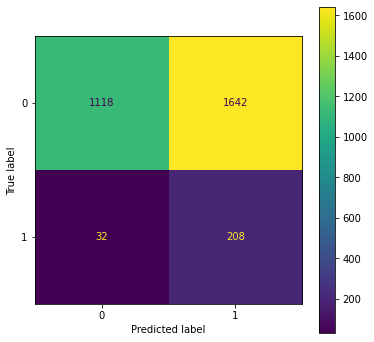

--- ROC AUC ---



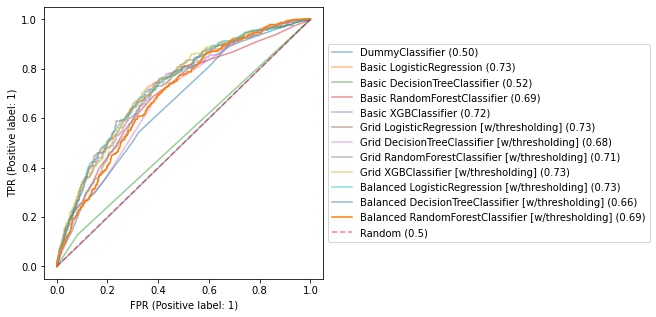

In [113]:
get_scores(f"Balanced {get_model_name(grd_rf['model'])} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True)

## 4. Balanced XGBoost Classifier Grid<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [114]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [115]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [116]:
grd_xgb = fit_model(
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

ROC_AUC: 0.4965402271897241
ROC_AUC: 0.519943703986779
ROC_AUC: 0.6319200137338504
ROC_AUC: 0.629988791293745
ROC_AUC: 0.6740576052489724

MEAN ROC_AUC: 0.5905 with STD: 0.0776


In [117]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 140,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.480499219968799,
 'seed': 0}

In [118]:
get_scores(f"Balanced {get_model_name(grd_xgb['model'])}", **grd_xgb, register=False, simple=True)

--- Balanced XGBClassifier ---

ROC AUC:0.7256227355072464
F1-score:0.24937655860349126
Recall:0.625



#### Let's find the best threshold *(based on F1 score)*

In [119]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_valid, y_valid, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24379232505643342) for this model is reached with a threshold of 0.47800000000000004


--- Balanced XGBClassifier [w/thresholding] ---

ROC AUC:0.7256227355072464
F1-score:0.24379232505643342
Recall:0.675

--- Classification Report ---

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.66      0.78      2760
Prediction = 1       0.15      0.68      0.24       240

      accuracy                           0.67      3000
     macro avg       0.55      0.67      0.51      3000
  weighted avg       0.89      0.67      0.74      3000

--- Confusion Matrix ---



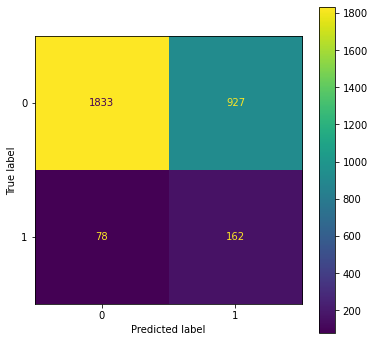

--- ROC AUC ---



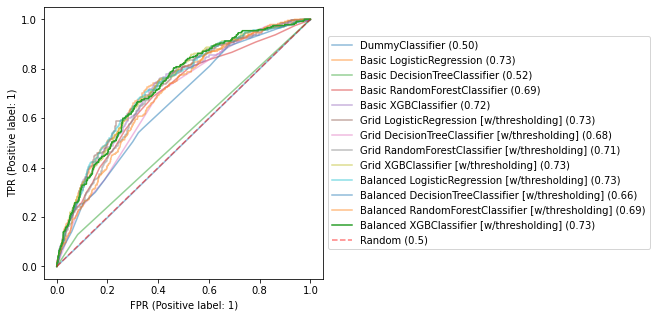

In [120]:
get_scores(f"Balanced {get_model_name(grd_xgb['model'])} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True)

## 5. Review scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [121]:
scores

,Method,threshold,params,ROC AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,0.500,"{'random_state': [0], 'strategy': ['stratified']}",0.498732,0.084291,0.840667,0.078014,0.091667,22,2500,260,218,1.213294,0.001280
1,Basic LogisticRegression,0.500,"{'random_state': [0], 'max_iter': [3000]}",0.726893,0.008065,0.918000,0.125000,0.004167,1,2753,7,239,35.735701,0.025318
2,Basic LogisticRegression [w/thresholding],0.220,"{'random_state': [0], 'max_iter': [3000]}",0.726893,0.218978,0.893000,0.263158,0.187500,45,2634,126,195,35.735701,0.010839
3,Basic DecisionTreeClassifier,0.500,{'random_state': [0]},0.523279,0.124248,0.854333,0.119691,0.129167,31,2532,228,209,2.119543,0.011485
4,Basic DecisionTreeClassifier [w/thresholding],0.125,{'random_state': [0]},0.523279,0.124248,0.854333,0.119691,0.129167,31,2532,228,209,2.119543,0.005133
5,Basic RandomForestClassifier,0.500,{'random_state': [0]},0.690861,0.000000,0.920000,0.000000,0.000000,0,2760,0,240,2.552000,0.097967
6,Basic RandomForestClassifier [w/thresholding],0.200,{'random_state': [0]},0.690861,0.216590,0.886667,0.242268,0.195833,47,2613,147,193,2.552000,0.051578
7,Basic XGBClassifier,0.500,"{'seed': [0], 'objective': ['binary:logistic']...",0.717571,0.068441,0.918333,0.391304,0.037500,9,2746,14,231,9.429600,0.031730
8,Basic XGBClassifier [w/thresholding],0.221,"{'seed': [0], 'objective': ['binary:logistic']...",0.717571,0.215962,0.888667,0.247312,0.191667,46,2620,140,194,9.429600,0.017824
9,Grid LogisticRegression [w/thresholding],0.207,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.727111,0.206897,0.892667,0.253012,0.175000,42,2636,124,198,29.775704,0.005946


In [122]:
scores[['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values('ROC AUC', ascending=False)

,Method,ROC AUC,F1 score,Recall
12,Grid XGBClassifier [w/thresholding],0.727433,0.204724,0.162500
13,Balanced LogisticRegression [w/thresholding],0.727319,0.193177,0.908333
9,Grid LogisticRegression [w/thresholding],0.727111,0.206897,0.175000
2,Basic LogisticRegression [w/thresholding],0.726893,0.218978,0.187500
1,Basic LogisticRegression,0.726893,0.008065,0.004167
16,Balanced XGBClassifier [w/thresholding],0.725623,0.243792,0.675000
7,Basic XGBClassifier,0.717571,0.068441,0.037500
8,Basic XGBClassifier [w/thresholding],0.717571,0.215962,0.191667
11,Grid RandomForestClassifier [w/thresholding],0.709695,0.191176,0.162500
15,Balanced RandomForestClassifier [w/thresholding],0.693426,0.199043,0.866667


In [123]:
sms.send("Balanced done")

JupyterScriptCompleted: Balanced done

# Custom metric <a class="anchor" id="custom_metric"></a> [⇪](#menu)

## 1. The problem <a class="anchor" id="custom_metric_problem"></a> [⇪](#menu)

>#### Let's interpret the four correlation matrix values in regards to this project:
> - `(TP) True Positive` : the client is predicted as NOT OK and it really is NOT OK. *(we **save** money)*
> - `(TN) True Negative` : the client is predicted as OK and it really is OK. *(we **earn** money)*
> - `(FP) False Positive` : the client is predicted as OK but it is in fact NOT OK. *(we **miss** money)*
> - `(FN) False Negative` : the client is predicted as NOT OK but it is in fact OK. *(we **lose** money)*
>
>#### So the goals in order of importance are:
> 1. minimize the `(FN) False Negative` to **avoid losing money**.
> 2. maximize the `(TN) True Negative` to **earn money**.
> 3. maximize the `(TP) True Positive` to save money.
> 4. minimize the `(FP) False Positive` to avoid missing money.

>#### Currently we are using the F1-measure and the ROC-AUC score.
>
> - The `F1-Measure` **balance the weight** on PRECISION and RECALL.
> - The `ROC AUC score`  summarize the **trade-off** between the true positive rate (RECALL) and false positive rate (ANTI-SPECIFICITY).
>

> RECALL = $\frac{TP}{TP + FN}$
> - High RECALL favors TP over FN
> - Low RECALL favors FN over TP

> PRECISION = $\frac{TP}{TP + FP}$
> - High PRECISION favors TP over FP
> - Low PRECISION favors FP over TP

> ANTI-SPECIFICITY = 1 - SPECIFICITY = 1 - $\frac{TN}{TN + FS}$ = $\frac{FP}{FP + TN}$
> - High ANTI-SPECIFICITY favors FP over TN
> - Low ANTI-SPECIFICITY favors TN over FP

## 2. F-measure <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)

> * `F0.5-Measure`: **More weight on precision**, less weight on recall.
> * `F1-Measure`  : **Balance the weight** on precision and recall.
> * `F2-Measure`  : **More weight on recall**, less weight on precision.

>#### And luckily, there exists a [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function in sklearn, which can be used to reproduce those F-measure and any in between measure... So we can in fact decide how much weight we want to give to RECALL.

>#### We want to maximize this `Fbeta-score` with beta > 1.0 !

In [ ]:
from sklearn.metrics import fbeta_score
fb_score = fbeta_score(y_test, y_pred_log, beta=2.0)
fb_score

# Feature Engineering

In [ ]:
data_application_full = pd.read_csv(
    zip_file.open('application_train.csv'),
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_full.shape

### What fraction of the price of the goods for which the loan is given, represent the credit amount?

In [ ]:
data_application_full['FRAC_GOODS_PRICE'] = data_application_full.AMT_CREDIT / data_application_full.AMT_GOODS_PRICE

In [ ]:
data_application_full[['AMT_CREDIT','AMT_GOODS_PRICE','FRAC_GOODS_PRICE']].head()

### How old was the client when it started his current employement position?

In [ ]:
data_application_full['AGE_EMPLOYEMENT'] = (data_application_full.DAYS_BIRTH - data_application_full.DAYS_EMPLOYED) / -365

In [ ]:
data_application_full[['DAYS_BIRTH','DAYS_EMPLOYED','AGE_EMPLOYEMENT']].head()

### What fraction of the total incomes per member of the family?

In [ ]:
data_application_full['INCOME_PER_FAM_MEMBER'] = data_application_full.AMT_INCOME_TOTAL / data_application_full.CNT_FAM_MEMBERS

In [ ]:
data_application_full[['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','INCOME_PER_FAM_MEMBER']].head()

### How many requests overall have been made to the credit bureau?

In [ ]:
data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data_application_full.AMT_REQ_CREDIT_BUREAU_HOUR +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_DAY +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_WEEK +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_MON +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_QRT +\
                                                        data_application_full.AMT_REQ_CREDIT_BUREAU_YEAR

In [ ]:
data_application_full[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_TOTAL']].head()

In [ ]:
data_application_train2 = data_application_train.copy()

In [ ]:
data_application_train2['FRAC_GOODS_PRICE'] = data_application_full['FRAC_GOODS_PRICE']
data_application_train2['AGE_EMPLOYEMENT'] = data_application_full['AGE_EMPLOYEMENT']
data_application_train2['INCOME_PER_FAM_MEMBER'] = data_application_full['INCOME_PER_FAM_MEMBER']
data_application_train2['AMT_REQ_CREDIT_BUREAU_TOTAL'] = data_application_full['AMT_REQ_CREDIT_BUREAU_TOTAL']

In [ ]:
correlations = data_application_train2.corr(method='pearson')

#### ---- Let's check for the top correlations with the `TARGET` variable ----

In [ ]:
view_size = 100
threshold = 0.0
corr_target = correlations.TARGET.sort_values(ascending=False)
print(f"{f'TOP POSITIVES > {threshold}'.rjust(40)}          {f'TOP NEGATIVES < -{threshold}'.rjust(40)}\n{'-'*100}")
for i, row in enumerate(zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size)))):
    
    print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")
    if((row[1] < threshold and row[3] > -threshold) or (i>=len(corr_target)//2)):
        break

In [ ]:
correlations = data_application_train.corr(method='pearson')

#### ---- Let's check for the top correlations with the `TARGET` variable ----

In [ ]:
view_size = 100
threshold = 0.0
corr_target = correlations.TARGET.sort_values(ascending=False)
print(f"{f'TOP POSITIVES > {threshold}'.rjust(40)}          {f'TOP NEGATIVES < -{threshold}'.rjust(40)}\n{'-'*100}")
for i, row in enumerate(zip(
    corr_target.head(view_size).index, corr_target.head(view_size), 
    reversed(corr_target.tail(view_size).index), reversed(corr_target.tail(view_size)))):
    
    print(f"{row[0].rjust(40)} : {row[1]:6.4f} {row[2].rjust(40)} : {row[3]:6.4f}")
    if((row[1] < threshold and row[3] > -threshold) or (i>=len(corr_target)//2)):
        break

In [ ]:
import FreeMobileSMS as sms
sms.send()

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci